Libraries used in this project

In [2]:
import pandas as pd
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,Bidirectional
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import keras_metrics
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
#STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
import chart_studio.plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Using TensorFlow backend.


In [1]:
!pip install keras_metrics

Loading the dataset


In [26]:
olidData=pd.read_csv('training_data.tsv', sep='\t')
olidData.tail()
olidData.text=olidData.text.astype(str)

,id,text,actual_label
0,1157097496465825792,artists use clip studio paint please dm looks ...,NOT
1,1159951246964547584,personORGillORGworkORGORGmightORGneedORGpens,NOT
2,1161854610727997440,person 1 mycareer trailer huh,NOT
3,1187418039719026689,aint settling piece shit ass hoes,"OFF, UNT"
4,1157363369898328064,person person yea 100 part group,NOT
...,...,...,...
134683,1160273231154176005,im done fucking gangbangs dumbass men love lik...,"OFF, UNT"
134684,1162081126774652929,get rid trump asap person,NOT
134685,1165255509202653185,exposing somebody love big l,NOT
134686,1160347194370809861,parents really inconsiderate fuck,"OFF, UNT"


In [0]:
testData=pd.read_csv('olid-training-v1.0.tsv', sep='\t')
testData['actual_label'] = olidData[['subtask_a', 'subtask_b', 'subtask_c']].apply(lambda x: ', '.join(x[x.notnull()]), axis = 1)
testData

Cleaning dataset


In [0]:
nlp = spacy.load("en_core_web_sm")
olidData = olidData.reset_index(drop=True)
re_space = re.compile('[/(){}\[\]\|@,;]')
re_symbols = re.compile('[^0-9a-z #+_]')
stop_words = set(stopwords.words('english'))
re_user=re.compile('(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)')

def clean_text(text):
    text=re_user.sub('Person', text)
    lower = text.lower()
    space_replace = re_space.sub(" ",lower)
    nosymb = re_symbols.sub("",space_replace)
    text = re.sub(r"\s*\b(?:{})\b".format("|".join(stop_words)), "", nosymb)
    doc = nlp(text)
    for entity in doc.ents:
      if entity.label_=="PERSON" or entity.label_=="NORP" or entity.label_=="ORG" or entity.label_=="GPE":
          text=text.replace(entity.text, entity.label_)
    return re.sub(r" {2,}", " ", text.strip())


Tokeninzing and preparing LSTM model

In [27]:
maxWords = 50000
maxLength = 250
embedDimension = 100

tokenizer = Tokenizer(num_words=maxWords, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(olidData['text'])
indexedWords = tokenizer.word_index
print('Found %s unique tokens.' % len(indexedWords))

X_train = tokenizer.texts_to_sequences(olidData['text'].values)
X_train = pad_sequences(X_train, maxlen=maxLength)
print('Shape of data tensor:', X_train.shape)

Y_train = pd.get_dummies(olidData['actual_label'])
print('Shape of label tensor:', Y_train.shape)

print(X_train.shape,Y_train.shape)

Found 77145 unique tokens.
Shape of data tensor: (134688, 250)
Shape of label tensor: (134688, 5)
(134688, 250) (134688, 5)


LSTM model


In [0]:
lstmModel = Sequential()
lstmModel.add(Embedding(maxWords, embedDimension, input_length=X_train.shape[1]))
lstmModel.add(SpatialDropout1D(0.2))
lstmModel.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
lstmModel.add(Dense(5, activation='softmax'))
lstmModel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',keras_metrics.precision(),keras_metrics.recall(),keras_metrics.f1_score()])
print(lstmModel.summary())

# LSTM model training
epochs = 5
batch_size = 64

history = lstmModel.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 505       
Total params: 5,080,905
Trainable params: 5,080,905
Non-trainable params: 0
_________________________________________________________________
None
Train on 121219 samples, validate on 13469 samples
Epoch 1/5
 43200/121219 [=========>....................] - ETA: 11:27 - loss: 0.5082 - acc: 0.8181 - precision: 0.9023 - recall: 0.9571 - f1_score: 0.9289

Reading Test Data

In [18]:
testData=pd.read_csv('testData.csv')
testData.tweet=testData.tweet.astype(str)
testdata

,Unnamed: 0,id,tweet,subtask_a,subtask_b,subtask_c,actual_label
0,0,86426,person ask native americans take,OFF,UNT,NaN,"OFF, UNT"
1,1,90194,person person go home youre drunk person #maga...,OFF,TIN,IND,"OFF, TIN, IND"
2,2,16820,amazon investigating chinese employees selling...,NOT,NaN,NaN,NOT
3,3,62688,person someone shouldvetaken piece shit volcano,OFF,UNT,NaN,"OFF, UNT"
4,4,43605,person person obama wanted liberals amp illega...,NOT,NaN,NaN,NOT
...,...,...,...,...,...,...,...
13235,13235,95338,person sometimes get strong vibes people mans ...,OFF,TIN,IND,"OFF, TIN, IND"
13236,13236,67210,benidorm creamfields maga shabby summer,NOT,NaN,NaN,NOT
13237,13237,82921,person report garbage dont give crap,OFF,TIN,OTH,"OFF, TIN, OTH"
13238,13238,27429,person pussy,OFF,UNT,NaN,"OFF, UNT"


Preparing and tokenizing test data for the model

In [19]:
tokenizer = Tokenizer(num_words=maxWords, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(testData['tweet'])
indexedWords = tokenizer.word_index
print('Found %s unique tokens.' % len(indexedWords))


X_test = tokenizer.texts_to_sequences(testData['tweet'].values)
X_test = pad_sequences(X_test, maxlen=maxLength)
print('Shape of data tensor:', X_test.shape)

Y_test = pd.get_dummies(testData['actual_label'])
print('Shape of label tensor:', Y_test.shape)

Found 20373 unique tokens.
Shape of data tensor: (13240, 250)
Shape of label tensor: (13240, 5)


Testing of LSTM model

In [20]:
accr = lstmModel.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}\n  Precision: {:0.3f}\n  Recall: {:0.3f}\n  F1Score: {:0.3f}'.format(accr[0],accr[1],accr[2],accr[3],accr[4]))

13240/13240 [==============================] - 28s 2ms/step
Test set
  Loss: 4.561
  Accuracy: 0.417
  Precision: 0.668
  Recall: 0.580
  F1Score: 0.621


Create dataframe using InsertPredictions function with the test data and predict.

In [0]:
import numpy as np

def InsertPredictions(test_data,model):
    lstNot=[]
    lstOffGrp=[]
    lstOffInd=[]
    lstOffOth=[]
    lstOffUnt=[]
    lst=["NOT","OFF, TIN, GRP","OFF, TIN, IND","OFF, TIN, OTH","OFF, UNT"]
    dd=testdata
    lst_text = dd['tweet'].tolist()
    y_prob = model.predict(test_data)
    for prob in y_prob:
      lstNot.append(prob[0])
      lstOffGrp.append(prob[1])
      lstOffInd.append(prob[2])
      lstOffOth.append(prob[3])
      lstOffUnt.append(prob[4])
    y_classes = y_prob.argmax(axis=-1)
    lst_classes=y_classes.tolist()
    lst_predictions = [lst[i] for i in lst_classes]
    lst_original=dd['actual_label'].tolist()
    lst_prob=y_prob.tolist()
    df = pd.DataFrame(lst_text,columns =['tweet'])
    df['Original']=lst_original
    df['Predictions']=lst_predictions
    df['Not Off.']=lstNot
    df['Off. Group']=lstOffGrp
    df['Off. Ind.']=lstOffInd
    df['Off. Others']=lstOffOth
    df['Off. Untargeted']=lstOffUnt
    lstSummary=[]
    for index, row in df.iterrows():
      if row['Original']==row['Predictions']:
        lstSummary.append(1)
      else:
        lstSummary.append(0)
    df['IsCorrect']=lstSummary
    return df

predicted=InsertPredictions(X_test,lstmModel)
predicted

#y_classes = keras.np_utils.probas_to_classes(y_proba)
#y_classes[0][0]

,tweet,Original,Predictions,Not Off.,Off. Group,Off. Ind.,Off. Others,Off. Untargeted,IsCorrect
0,person ask native americans take,"OFF, UNT",NOT,0.996821,1.132035e-03,4.471898e-05,1.959440e-03,4.277546e-05,0
1,person person go home youre drunk person #maga...,"OFF, TIN, IND",NOT,0.999383,2.427596e-04,1.069936e-04,2.518734e-04,1.519497e-05,0
2,amazon investigating chinese employees selling...,NOT,NOT,0.997559,1.495147e-04,2.253259e-05,2.216617e-03,5.248560e-05,1
3,person someone shouldvetaken piece shit volcano,"OFF, UNT","OFF, TIN, IND",0.000043,3.289724e-03,6.974528e-01,1.726195e-01,1.265945e-01,0
4,person person obama wanted liberals amp illega...,NOT,NOT,0.999861,1.062854e-04,2.477088e-06,2.919721e-05,7.809057e-07,1
...,...,...,...,...,...,...,...,...,...
13235,person sometimes get strong vibes people mans ...,"OFF, TIN, IND","OFF, TIN, GRP",0.185298,6.199777e-01,1.848053e-01,4.357410e-03,5.561950e-03,0
13236,benidorm creamfields maga shabby summer,NOT,"OFF, TIN, GRP",0.366661,4.906460e-01,3.541188e-02,8.225346e-02,2.502730e-02,0
13237,person report garbage dont give crap,"OFF, TIN, OTH","OFF, TIN, OTH",0.001019,2.231188e-01,5.730192e-02,6.811059e-01,3.745391e-02,1
13238,person pussy,"OFF, UNT","OFF, TIN, IND",0.001083,9.696815e-02,8.665940e-01,8.153748e-03,2.720166e-02,0


In [0]:
def calScores(frame):
  lst=['NOT','OFF, TIN, GRP','OFF, TIN, IND','OFF, TIN, OTH','OFF, UNT']
  lstFscore=[]
  for item in lst:
    tp=len(frame[(frame['IsCorrect']==1) & (frame['Predictions']==item)])
    fp=len(frame[(frame['IsCorrect']==0) & (frame['Predictions']==item)])
    #precision=tp/tp+fp
    precision=tp/(tp+fp)
    print("Precision for "+item+" : "+str(precision))
    fn=len(frame[(frame['Original']==item) & (frame['Predictions']!=item)])
    recall=tp/(tp+fn)
    print("Recall for "+item+" : "+str(recall))
    fScore=(2*precision*recall)/(precision+recall)
    lstFscore.append(fScore)
  return lstFscore

tp=len(predicted[(predicted['IsCorrect']==1) & (predicted['Predictions']=='OFF, UNT')])
fp=len(predicted[(predicted['IsCorrect']==0) & (predicted['Predictions']=='OFF, UNT')])
print(tp,fp)
calScores(predicted)

6 11
Precision for NOT : 0.7713333986479867
Recall for NOT : 0.8906108597285067
Precision for OFF, TIN, GRP : 0.2718204488778055
Recall for OFF, TIN, GRP : 0.4059590316573557
Precision for OFF, TIN, IND : 0.6144708423326134
Recall for OFF, TIN, IND : 0.23639385126713752
Precision for OFF, TIN, OTH : 0.11316872427983539
Recall for OFF, TIN, OTH : 0.13924050632911392
Precision for OFF, UNT : 0.35294117647058826
Recall for OFF, UNT : 0.011450381679389313


[0.8266918674856932,
 0.3256161314413742,
 0.3414341434143414,
 0.12485811577752552,
 0.022181146025878003]

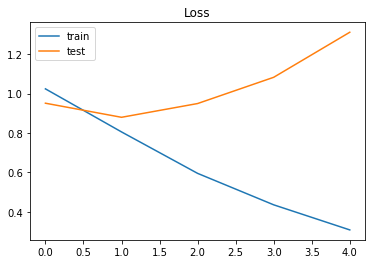

In [0]:

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

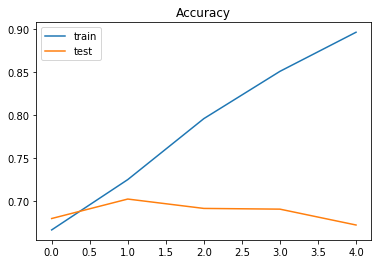

In [0]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

In [0]:
apiData=pd.read_csv('apiData.csv', sep='\t')
apiData

,Unnamed: 0,id,id_str,text,user_id,user_screen_name,created_at
0,0,1205982163549728769,1205982163549728769,RT @BruthaManTho: #ArmyNavyGame nothing like s...,772787304,ArriolaAnn,Sat Dec 14 22:45:28 +0000 2019
1,1,1205982164061446146,1205982164061446146,RT @bbcstrictly: The #Strictly class of 2019 a...,91434042,em_katexo,Sat Dec 14 22:45:28 +0000 2019
2,2,1205982164094988288,1205982164094988288,@MissFrance Miss Provence !,1088924476975263746,CharlotteTaquet,Sat Dec 14 22:45:28 +0000 2019
3,3,1205982164153782273,1205982164153782273,#StrictlyFinal I know the standard is good in ...,917385627649429504,Julie_Dawson12,Sat Dec 14 22:45:28 +0000 2019
4,4,1205982164988256256,1205982164988256256,RT @Michy043: ARMY please read this is really ...,1147779470285164545,lovinjintaekook,Sat Dec 14 22:45:28 +0000 2019
...,...,...,...,...,...,...,...
40496,40496,1206003770741710849,1206003770741710849,#BTSWin10s @BTS_twt &amp; ARMY \r\nhttps://t...,469279642,L0vehaEhyuk,Sun Dec 15 00:11:20 +0000 2019
40497,40497,1206003771475668992,1206003771475668992,RT @avenaim: Trumps America #ArmyNavyGame a bu...,756510191332560896,Picklesnova,Sun Dec 15 00:11:20 +0000 2019
40498,40498,1206003771563761664,1206003771563761664,RT @escapedmatrix: After military officials pu...,899415992056631303,RobinPrice_ATL,Sun Dec 15 00:11:20 +0000 2019
40499,40499,1206003772012605471,1206003772012605471,"RT @mmpadellan: As an American,\r\nAs a Navy D...",494042942,CathySturgis,Sun Dec 15 00:11:20 +0000 2019


In [0]:
apiData['text'] = apiData['text'].apply(clean_text)
apiData

,Unnamed: 0,id,id_str,text,user_id,user_screen_name,created_at
0,0,1205982163549728769,1205982163549728769,rt person #armynavygame nothing like seeing bu...,772787304,ArriolaAnn,Sat Dec 14 22:45:28 +0000 2019
1,1,1205982164061446146,1205982164061446146,rt person #strictly class 2019 back ballroom b...,91434042,em_katexo,Sat Dec 14 22:45:28 +0000 2019
2,2,1205982164094988288,1205982164094988288,person miss provence,1088924476975263746,CharlotteTaquet,Sat Dec 14 22:45:28 +0000 2019
3,3,1205982164153782273,1205982164153782273,#strictlyfinal know standard good final seems ...,917385627649429504,Julie_Dawson12,Sat Dec 14 22:45:28 +0000 2019
4,4,1205982164988256256,1205982164988256256,rt person army please read really important le...,1147779470285164545,lovinjintaekook,Sat Dec 14 22:45:28 +0000 2019
...,...,...,...,...,...,...,...
40496,40496,1206003770741710849,1206003770741710849,#btswin10s person amp army https tco kg0ccwu81o,469279642,L0vehaEhyuk,Sun Dec 15 00:11:20 +0000 2019
40497,40497,1206003771475668992,1206003771475668992,rt person trumps america #armynavygame bunch c...,756510191332560896,Picklesnova,Sun Dec 15 00:11:20 +0000 2019
40498,40498,1206003771563761664,1206003771563761664,rt person military officials publicly emphasiz...,899415992056631303,RobinPrice_ATL,Sun Dec 15 00:11:20 +0000 2019
40499,40499,1206003772012605471,1206003772012605471,rt person NORP navy dad decent human beingyou ...,494042942,CathySturgis,Sun Dec 15 00:11:20 +0000 2019
